In [1]:
# COSMIC RAY REMOVAL
# Detect cosmic ray spikes based on second difference exceeding predefined threshold & replace spikes with linearly interpolated values from neighboring data points
import pandas as pd
import numpy as np

file_path = '/kaggle/input/synthetic-spect-xy/synthetic_spectra_xy.csv'
data = pd.read_csv(file_path)

# Actual column names
wave_column = 'Wave'
intensity_column = 'Intensity'

# Calculate the second difference of the spectrum to accentuate sharp spikes
first_difference = np.diff(data[intensity_column], n=1)
second_difference = np.diff(first_difference, n=1)

# Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
threshold = 0.2
cosmic_ray_indices = np.where(second_difference > threshold)[0]

# Replace these points using linear interpolation from neighboring data points
for index in cosmic_ray_indices:
    if index - 1 >= 0 and index + 1 < len(data): # index must be within a valid range
        left_neighbor = data.at[index - 1, intensity_column]
        right_neighbor = data.at[index + 1, intensity_column]

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        data.at[index, intensity_column] = interpolated_value

# RIGHT CODE
import numpy as np
import pandas as pd

# Load data into DataFrame
df = pd.read_csv('/kaggle/input/synthetic-spect-xy/synthetic_spectra_xy.csv')

# Access columns from DataFrame
wavelengths = df['Wavelength']
intensities = df['Intensity']

# 1. Identify Baseline Regions
def identify_baseline_regions(spectrum, min_peak_height=0.01):
    # Implement algorithm to identify baseline regions in the spectrum
    # Parameters: spectrum: Raman spectrum as a numpy array of intensity values & min_peak_height: Minimum peak height to consider a point as a peak
    # Returns: list of tuples specifying start & end indices of baseline regions
    
    # Find local minima in spectrum
    is_peak = (spectrum < np.roll(spectrum, 1)) & (spectrum < np.roll(spectrum, -1))

    baseline_regions = []
    region_start = 0

    for i in range(1, len(spectrum) - 1):
        if is_peak[i]:
            # If previous region is long enough, consider it a baseline region
            if i - region_start > 2:
                baseline_regions.append((region_start, i))
            region_start = i + 1

    # Check if last region is a baseline region
    if region_start < len(spectrum) - 1:
        baseline_regions.append((region_start, len(spectrum) - 1))

    # Filter regions based on peak height
    baseline_regions = [region for region in baseline_regions if np.min(spectrum[region[0]:region[1] + 1]) < min_peak_height]

    return baseline_regions

# Apply baseline identification function to intensities array
baseline_regions = identify_baseline_regions(intensities)

# 2. Fit Chebyshev Polynomials to Baseline Regions
for start, end in baseline_regions:
    # Get wavelengths & intensities in baseline region
    baseline_wavelengths = wavelengths[start:end]
    baseline_intensities = intensities[start:end]
    
    # Fit Chebyshev polynomial to baseline region
    poly_order = 3
    coeffs = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)

# 3. Update Fitted Curve 
# Implement an iterative loop to update fitted polynomial to ensure it remains beneath spectrum
def identify_baseline_region(index):
    # Given an index where fitted curve exceeds the spectrum, identify corresponding baseline region
    # use baseline regions previously identified to find the one that contains the index
    for start, end in baseline_regions:
        if start <= index <= end:
            return start, end
    return None  # Return None if no matching baseline region is found

# Set a maximum number of iterations to avoid infinite loops
max_iterations = 10

for iteration in range(max_iterations):
    # Evaluate fitted polynomial over entire spectrum range
    fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs)

    # Check if any part of fitted curve is above the spectrum
    exceed_indices = np.where(fitted_baseline > intensities)[0]

    if len(exceed_indices) == 0:
        # If no part of fitted curve exceeds the spectrum, break loop
        break

    # Update fitted polynomial in regions where it exceeds the spectrum
    for index in exceed_indices:
        # Identify corresponding baseline region
        baseline_region = identify_baseline_region(index)
        
        if baseline_region is not None:
            start, end = baseline_region
            # Get the wavelengths & intensities in baseline region
            baseline_wavelengths = wavelengths[start:end]
            baseline_intensities = intensities[start:end]

            # Fit a new Chebyshev polynomial to baseline region
            new_coeffs = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)

            # Update coefficients where they exceeded the spectrum
            coeffs[start:end] = new_coeffs[start:end]

# 4. Subtract Fitted Polynomial
# Evaluate fitted polynomial over entire spectrum range
fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs)

# Subtract fitted baseline from original spectrum to correct baseline
corrected_spectrum = intensities - fitted_baseline

/opt/conda/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


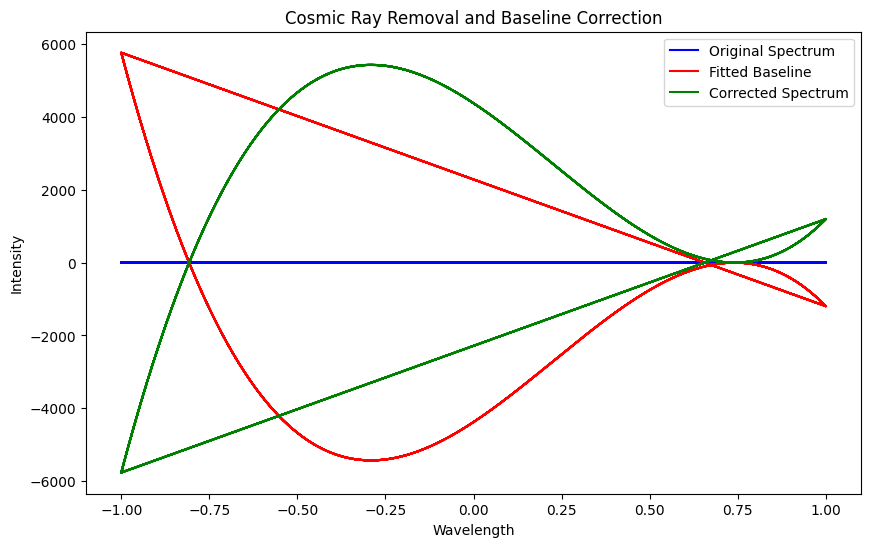

In [2]:
import matplotlib.pyplot as plt

# Plot original spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, intensities, label='Original Spectrum', color='b')

# Plot fitted baseline
plt.plot(wavelengths, fitted_baseline, label='Fitted Baseline', color='r')

# Plot corrected spectrum
plt.plot(wavelengths, corrected_spectrum, label='Corrected Spectrum', color='g')

# Add labels and legend
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()

# Show the plot
plt.title('Cosmic Ray Removal and Baseline Correction')
plt.show()